In [1]:
import os
from time import strftime, localtime
import pickle

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy.fft import fft

%matplotlib inline

In [2]:
def make_dataset(F0, F1, time, random_phase=False, mu=0.0, sigma=0.0):
    N_samples = time.shape[0]
    if F1 is None:
        N_entries = len(F0)
    else:
        N_entries = len(F0) * len(F1)

    if random_phase:
        phi = tf.random.uniform(shape=[N_entries], minval=0, maxval=np.pi)
    else:
        phi = tf.zeros(N_entries)
        
    if F1 is None:
        x = tf.constant([np.sin(2 * np.pi * f * time + phi) for f,phi in zip(F0, phi)])
        y = tf.constant(list(map(float, F0)), shape=(len(F0),1))
    else:
        x = np.zeros((N_entries, N_samples), dtype=np.float32)
        y = np.zeros((N_entries, 2), dtype=np.float32)
        k = 0
        for f0 in F0:
            for f1 in F1:
                c = (f1 - f0) / time[-1]
                F = c * time + f0
                x[k] = np.sin(2 * np.pi * F * time + phi[k])
                y[k,0] = f0
                y[k,1] = f1
                k += 1
        x = tf.constant(x)
        y = tf.constant(y)
    if mu != 0.0 or sigma > 0.0:
        x = tf.math.add(x, tf.random.normal(shape=x.shape, mean=mu, stddev=sigma))
    return x, y

First, let's fix the seed of the RNG, for reproducibility purposes

In [3]:
use_good_sinusoidal = True
use_good_chirp = False

with open('/dev/random', 'rb') as fid:
    seed = int.from_bytes(fid.read(4), 'little')

if use_good_sinusoidal:
    seed = 1870310641
elif use_good_chirp:
    seed = 1794354334

tf.random.set_seed(seed)

print('Seed: {}'.format(seed))

Seed: 1870310641


#### Create the data

In [4]:
data_type = 'sinusoidal'

tend = 1.

random_phase = False
mu = 0.0
sigma = 0.5

if data_type == 'sinusoidal':
    N = 1000
    N_reps = 250

    time = tf.linspace(0., tend, N)

    df = 1.5
    F_train = tf.range(10., 70. + df/2, df)
    F_val = F_train[:-1] + 2. / 3. * df
    F_test = F_train[:-1] + df / 3.
    F_train = tf.keras.backend.flatten(tf.transpose(tf.reshape(tf.tile(F_train, tf.constant([N_reps], tf.int32)),  
                                                           [N_reps, len(F_train)])))

    x_train, y_train = make_dataset(F_train, None, time, random_phase, mu, sigma)
    x_test, y_test = make_dataset(F_test, None, time, random_phase, mu, sigma)
    x_val, y_val = make_dataset(F_val, None, time, random_phase, mu, sigma)

elif data_type == 'chirp':
    N = 10000

    time = np.linspace(0, tend, N)

    df0 = 3
    df1 = 6
    F0_train = np.r_[10 : 70 + df0/2 : df0]
    F1_train = np.r_[100 : 220 + df1/2 : df1]
    F0_val = F0_train[:-1] + 2. / 3. * df0
    F1_val = F1_train[:-1] + 2. / 3. * df1
    F0_test = F0_train[:-1] + 1. / 3. * df0
    F1_test = F1_train[:-1] + 1. / 3. * df1

    x_train, y_train = make_dataset(F0_train, F1_train, time, random_phase, mu, sigma)
    x_test, y_test = make_dataset(F0_test, F1_test, time, random_phase, mu, sigma)
    x_val, y_val = make_dataset(F0_val, F1_val, time, random_phase, mu, sigma)

In [9]:
y_train.shape

TensorShape([10250, 1])

#### Normalize the data

In [5]:
x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)
x_train = (x_train - x_train_mean) / x_train_std
x_test = (x_test - x_train_mean) / x_train_std
x_val = (x_val - x_train_mean) / x_train_std

Let's take a look at the data:

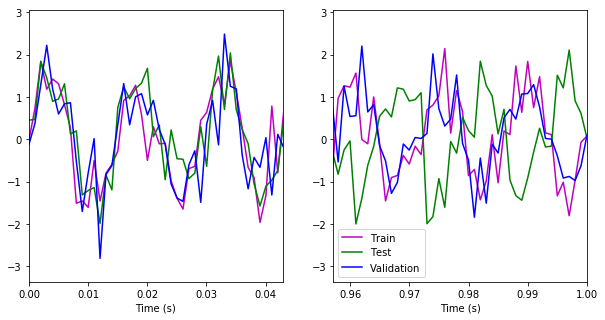

In [6]:
idx = -1
fig,(ax1,ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.plot(time, x_train[idx], 'm')
ax1.plot(time, x_val[idx], 'g')
ax1.plot(time, x_test[idx], 'b')
ax1.set_xlabel('Time (s)')
ax2.plot(time, x_train[idx], 'm', label='Train')
ax2.plot(time, x_val[idx], 'g', label='Test')
ax2.plot(time, x_test[idx], 'b', label='Validation')
if data_type == 'sinusoidal':
    ax1.set_xlim([0, 3/F_train[idx]])
    ax2.set_xlim([time[-1] - 3/F_train[idx], time[-1]])
elif data_type == 'chirp':
    ax1.set_xlim([0, 3/F0_train[idx]])
    ax2.set_xlim([time[-1] - 3/F0_train[idx], time[-1]])
ax2.legend(loc='best')
ax2.set_xlabel('Time (s)');

#### Use FFT to extract the frequency of the sinusoids in the test set

In [7]:
if data_type == 'sinusoidal':
    x_test_fft = fft(x_test.numpy(), axis=1)
    x_test_fft_mag = 2.0 / N * np.abs(x_test_fft[:, 0:N//2])
    idx = np.argmax(x_test_fft_mag, axis=1)
    freq = np.linspace(0.0, 1.0 / (2.0 * np.diff(time[:2])), N//2)
    y_fft = freq[idx]

### Build the network
The network topology used here is taken from the following paper:

George, D., & Huerta, E. A. (2018). Deep neural networks to enable real-time multimessenger astrophysics. Physical Review D, 97(4), 044039. http://doi.org/10.1103/PhysRevD.97.044039

In [8]:
with_dropout = False
dropout_coeff = 0.2
depth_level = 2
learning_rate = 1e-4

N_units = {}

if depth_level == 1:
    N_units['conv'] = [16, 32, 64]
elif depth_level == 2:
    N_units['conv'] = [64, 128, 256, 512]

N_units['pooling'] = [4 for _ in range(len(N_units['conv']))]
kernel_size = [5 for _ in range(len(N_units['conv']))]

model = tf.keras.models.Sequential([
    tf.keras.layers.Reshape((N,1), input_shape=(N,)),
])

for N_conv,N_pooling,sz in zip(N_units['conv'], N_units['pooling'], kernel_size):
    model.add(tf.keras.layers.Conv1D(N_conv, sz, activation=None))
    model.add(tf.keras.layers.MaxPooling1D(N_pooling))
    model.add(tf.keras.layers.ReLU())
    
model.add(tf.keras.layers.Flatten())
if depth_level == 2:
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    
model.add(tf.keras.layers.Dense(64, activation='relu'))

if with_dropout:
    model.add(tf.keras.layers.Dropout(dropout_coeff))

model.add(tf.keras.layers.Dense(y_train.shape[1]))

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
loss = tf.keras.losses.MeanAbsoluteError()

model.compile(optimizer=optimizer, loss=loss)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 1000, 1)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 996, 64)           384       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 249, 64)           0         
_________________________________________________________________
re_lu (ReLU)                 (None, 249, 64)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 245, 128)          41088     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 61, 128)           0         
_________________________________________________________________
re_lu_1 (ReLU)               (None, 61, 128)           0

#### Train the network

In [9]:
ts = strftime('%Y%m%d-%H%M%S', localtime())
path = 'parameter_extraction_models/' + data_type + '/' + ts
# checkpoint_path = path + '/checkpoints'

# # Create a callback that saves the model's weights
# cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
#                                                  save_weights_only=True,
#                                                  verbose=0)

EPOCHS = 10
BATCH_SIZE = 128
N_batches = np.ceil(x_train.shape[0] / BATCH_SIZE)
STEPS_PER_EPOCH = np.max([N_batches, 100])
history = model.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE,
                    steps_per_epoch=STEPS_PER_EPOCH, validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
100/100 [==============================] - 29s 286ms/step - loss: 20.1019 - val_loss: 6.0382
Epoch 2/10
100/100 [==============================] - 31s 312ms/step - loss: 3.1813 - val_loss: 2.1978
Epoch 3/10
100/100 [==============================] - 31s 308ms/step - loss: 1.5303 - val_loss: 1.2445
Epoch 4/10
100/100 [==============================] - 30s 300ms/step - loss: 1.0470 - val_loss: 0.9971
Epoch 5/10
100/100 [==============================] - 28s 278ms/step - loss: 0.9635 - val_loss: 1.0137
Epoch 6/10
100/100 [==============================] - 41s 407ms/step - loss: 0.8808 - val_loss: 0.9273
Epoch 7/10
100/100 [==============================] - 34s 341ms/step - loss: 0.8965 - val_loss: 0.9080
Epoch 8/10
100/100 [==============================] - 35s 350ms/step - loss: 0.8578 - val_loss: 0.9130
Epoch 9/10
 10/100 [==>...........................] - 3s 285ms/step - loss: 0.8168 - val_loss: 0.8917


#### Plot the loss as a function of the epoch number

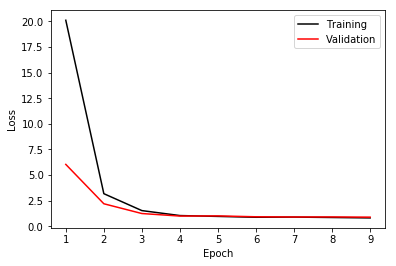

In [10]:
epochs = np.r_[0 : len(history.history['loss'])] + 1
plt.plot(epochs, history.history['loss'], 'k', label='Training')
plt.plot(epochs, history.history['val_loss'], 'r', label='Validation')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.ylabel('Loss');

#### Compute the network prediction on the test set

In [11]:
y_cnn = model.predict(x_test)

#### Compute the Mean Absolute Percentage Error on the CNN and FFT predictions

In [12]:
mape_cnn = tf.keras.losses.mean_absolute_percentage_error(tf.transpose(y_test), tf.transpose(y_cnn)).numpy()[0]
if data_type == 'sinusoidal':
    mape_fft = tf.keras.losses.mean_absolute_percentage_error(tf.transpose(y_test), tf.transpose(y_fft)).numpy()[0]
    print('MAPE on FFT prediction ... {:.2f}%'.format(mape_fft))
print('MAPE on CNN prediction ... {:.2f}%'.format(mape_cnn))

MAPE on FFT prediction ... 0.94%
MAPE on CNN prediction ... 1.75%


#### Plot the results obtained with the CNN

(and compare them with those obtained with the FFT if using just sinusoidal data)

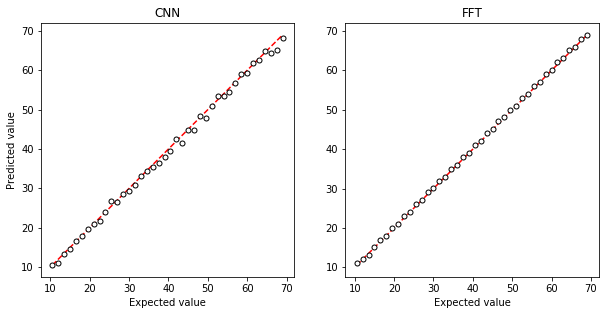

In [13]:
if data_type == 'sinusoidal':
    fig,ax = plt.subplots(1, 2, sharex=True, figsize=(10,5))
    limits = y_test.numpy()[[0,-1]]
    
    ax[0].plot(limits, limits, 'r--')
    ax[0].plot(y_test, y_cnn, 'ko', markersize=5, markerfacecolor='w', markeredgewidth=1)
    ax[0].axis('square')
    ax[0].set_title('CNN')
    ax[0].set_xlabel('Expected value')
    ax[0].set_ylabel('Predicted value')

    ax[1].plot(limits, limits, 'r--')
    ax[1].plot(y_test, y_fft, 'ko', markersize=5, markerfacecolor='w', markeredgewidth=1)
    ax[1].axis('square')
    ax[1].set_title('FFT')
    ax[1].set_xlabel('Expected value');

elif data_type == 'chirp':
    fig,ax = plt.subplots(1, 2, figsize=(10,5))
    for i in range(2):
        limits = y_test.numpy()[[0,-1],i]
        ax[i].plot(limits, limits, 'r--')
        ax[i].plot(y_test[:,i], y_cnn[:,i], 'ko', markersize=5, markerfacecolor='w', markeredgewidth=1)
        ax[i].set_xlabel('Expected value')
        ax[i].set_title('F{}'.format(i))
    ax[0].set_ylabel('Predicted value');

In [14]:
parameters = {'tend': tend, 'random_phase': random_phase, 'mu': mu, 'sigma': sigma,
              'N_samples': N, 'data_type': data_type, 'seed': seed, 'with_dropout': with_dropout,
              'depth_level': depth_level, 'N_units': N_units, 'kernel_size': kernel_size,
              'N_epochs': EPOCHS, 'batch_size': BATCH_SIZE, 'steps_per_epoch': STEPS_PER_EPOCH,
              'mape_cnn': mape_cnn, 'learning_rate': learning_rate, 'y_test': y_test, 'y_cnn': y_cnn}
if data_type == 'sinusoidal':
    parameters['df'] = df
    parameters['F_train'] = F_train
    parameters['F_val'] = F_val
    parameters['F_test'] = F_test
    parameters['mape_fft'] = mape_fft
    parameters['y_fft'] = y_fft
elif data_type == 'chirp':
    parameters['df0'] = df0
    parameters['df1'] = df1
    parameters['F0_train'] = F0_train
    parameters['F1_train'] = F1_train
    parameters['F0_val'] = F0_val
    parameters['F1_val'] = F1_val
    parameters['F0_test'] = F0_test
    parameters['F1_test'] = F1_test

In [15]:
path

NameError: name 'path' is not defined

In [ ]:
model.save(path)
pickle.dump(parameters, open(path + '/parameters.pkl', 'wb'))
pickle.dump(history.history, open(path + '/history.pkl', 'wb'))

In [ ]:
y_test.numpy().T

In [ ]:
y_cnn.T

Let's try to reload the model

In [ ]:
path = 'parameter_extraction_models/chirp/20200915-172605'

In [ ]:
model = tf.keras.models.load_model(path)
parameters = pickle.load(open(path + '/parameters.pkl', 'rb'))

In [ ]:
model.summary()

In [ ]:
tf.random.set_seed(parameters['seed'])

In [ ]:
time = np.linspace(0, parameters['tend'], parameters['N_samples'])

if parameters['data_type'] == 'sinusoidal':
    x_train, _ = make_dataset(parameters['F_train'], None, time, \
                              parameters['random_phase'], parameters['mu'], parameters['sigma'])
    x_test, y_test = make_dataset(parameters['F_test'], None, time, \
                              parameters['random_phase'], parameters['mu'], parameters['sigma'])
elif parameters['data_type'] == 'chirp':
    x_train, _ = make_dataset(parameters['F0_train'], parameters['F1_train'], time, \
                              parameters['random_phase'], parameters['mu'], parameters['sigma'])
    x_test, y_test = make_dataset(parameters['F0_test'], parameters['F1_test'], time, \
                              parameters['random_phase'], parameters['mu'], parameters['sigma'])

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)
x_train = (x_train - x_train_mean) / x_train_std
x_test = (x_test - x_train_mean) / x_train_std

In [ ]:
y_cnn = model.predict(parameters['x_test'])

In [ ]:
mape_cnn = tf.keras.losses.mean_absolute_percentage_error(tf.transpose(y_test), tf.transpose(y_cnn)).numpy()[0]
print('MAPE on CNN prediction ... {:.2f}%'.format(mape_cnn))

In [ ]:
tf.transpose(y_test)

In [ ]:
y_cnn.T

In [ ]:
parameters['y_cnn'].T